<h1>Modelo de transferencia de aprendizaje VGG16 para OCT macular</h1>

1. Conexión a data en drive

In [ ]:
# Conexión a drive almacen de las imagenes
from google.colab import drive
drive.mount('/content/Drive') 

Mounted at /content/Drive


2. Visualización de parametros de GPU asignada

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Sep 15 17:25:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    22W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

3. Visualización de parametros de memoria asignada

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


4. Importación de las librerias necesarias para el modelo y la manipulación de los datos

In [ ]:
# Importación de librerias
import numpy as np
import sys
import os
from tensorflow import keras
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.metrics import SensitivityAtSpecificity, Precision, Recall, SpecificityAtSensitivity
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import applications
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

5. Lista de los parámetros de la red convolucional y Kfold cross valitadion


In [ ]:
epocas = 55
longitud, altura = 496, 496
batch_size = 32
filtrosConv1 = 256
tamano_filtro1 = (3, 3)
tamano_pool = (2, 2)
clases = 4
lr = 0.0001
num_folds = 5

6. Ruta de las imágenes de entrenamiento, validación y prueba.

In [ ]:
# Cargue de las imagenes..Ruta
rutatrain = ['/content/Drive/My Drive/IA/Proyectos/K1/train/',
        '/content/Drive/My Drive/IA/Proyectos/K2/train/',
        '/content/Drive/My Drive/IA/Proyectos/K3/train/',
        '/content/Drive/My Drive/IA/Proyectos/K4/train/',
        '/content/Drive/My Drive/IA/Proyectos/K5/train/']

rutaval = ['/content/Drive/My Drive/IA/Proyectos/K1/val/',
        '/content/Drive/My Drive/IA/Proyectos/K2/val/',
        '/content/Drive/My Drive/IA/Proyectos/K3/val/',
        '/content/Drive/My Drive/IA/Proyectos/K4/val/',
        '/content/Drive/My Drive/IA/Proyectos/K5/val/']     

rutatest = ['/content/Drive/My Drive/IA/Proyectos/test/']      

7. Activación de parámetro de multiproceso

In [ ]:
import multiprocessing
manager = multiprocessing.Manager()
queue = manager.Queue(maxsize=80000)

8. Creación de vectores para acumular las métricas

In [ ]:
# Vectores de acumulación 
acc_per_fold = []
loss_per_fold = []
se_per_fold = []
sp_per_fold = []
rc_per_fold = []
pc_per_fold = []

9. Creacion de la K-fold Cross Validation, creación de modelo de transferencia de aprendizaje, compilación, entrenamiento y evaluación del modelo.

In [ ]:
# Generación del modelo
def modelo():
  vgg=applications.vgg16.VGG16(weights='imagenet',
                include_top=False,
                input_shape=(496, 496, 3)) # carga el modelo VGG16 en la variable vgg 
  cnn=Sequential()               # crea un modelo vacio del tipo secuencial
  for layer in vgg.layers:       # Transfiere las capas de vgg al modelo secuencial vacio cnn
      cnn.add(layer)
  cnn.pop()                      # Elimina la última capa de predicción
  for layer in cnn.layers:       # Recorre y hace que no vuelvan a entrenar 
      layer.trainable=False
      # Se adicionan capas no entrenadas
  cnn.add(MaxPooling2D(pool_size=tamano_pool))
  cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding ="same", activation='relu'))
  cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding ="same", activation='relu'))
  cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding ="same", activation='relu'))
  cnn.add(MaxPooling2D(pool_size=tamano_pool))
  cnn.add(Flatten())
  cnn.add(Dense(256, activation='relu'))
  cnn.add(Dropout(0.5))
  cnn.add(Dense(clases, activation='softmax')) # agrega capa de 4 neuronas para las 4 clases a clasificar
  
  return cnn

K.clear_session()

10. visualización del modelo y sus parámetros

In [ ]:
cnn=modelo()
cnn.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 496, 496, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 496, 496, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 248, 248, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 248, 248, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 248, 248, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 124, 124, 128)     0         
_________________________________________________________

11. Proceso de entrenamiento con K-Fold Cross Validation

Found 25176 images belonging to 4 classes.
Found 6210 images belonging to 4 classes.
Found 25176 images belonging to 4 classes.
Found 6210 images belonging to 4 classes.
------------------------------------------------------------------------
Entrenamiento para K-fold 1 ...
Epoch 1/55
112/112 [==============================] - 2274s 20s/step - loss: 1.3057 - accuracy: 0.3956 - mse: 0.1716 - recall: 0.1468 - precision: 0.5871 - val_loss: 0.8211 - val_accuracy: 0.6645 - val_mse: 0.1141 - val_recall: 0.5699 - val_precision: 0.7743
Epoch 2/55
112/112 [==============================] - 1923s 17s/step - loss: 0.7841 - accuracy: 0.6756 - mse: 0.1114 - recall: 0.5817 - precision: 0.7258 - val_loss: 0.6512 - val_accuracy: 0.7812 - val_mse: 0.0851 - val_recall: 0.7031 - val_precision: 0.8261
Epoch 3/55
112/112 [==============================] - 1643s 15s/step - loss: 0.5856 - accuracy: 0.7765 - mse: 0.0814 - recall: 0.7307 - precision: 0.7973 - val_loss: 0.5353 - val_accuracy: 0.7977 - val_mse: 

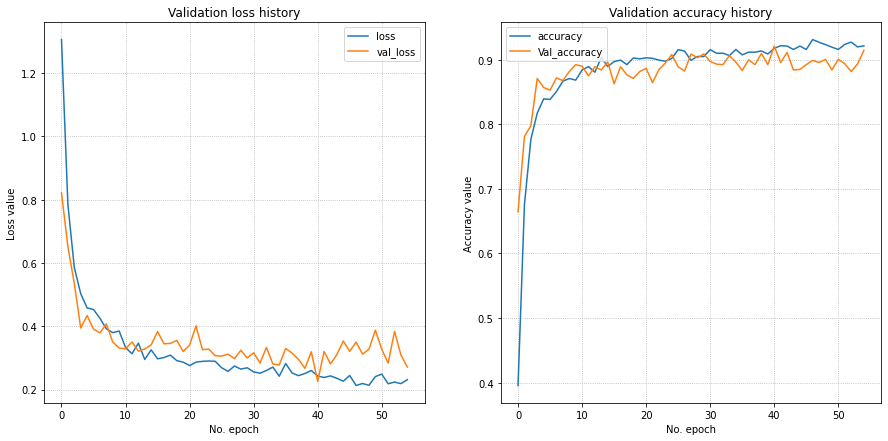

<Figure size 432x288 with 0 Axes>

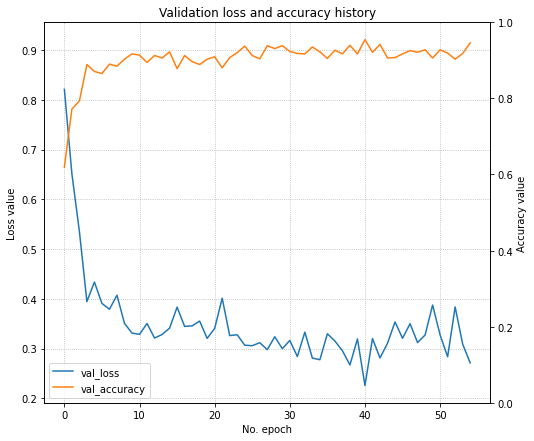

Found 25176 images belonging to 4 classes.
Found 6210 images belonging to 4 classes.
Found 25176 images belonging to 4 classes.
Found 6210 images belonging to 4 classes.
------------------------------------------------------------------------
Entrenamiento para K-fold 2 ...
Epoch 1/55
112/112 [==============================] - 188s 2s/step - loss: 1.2779 - accuracy: 0.3912 - mse: 0.1724 - recall: 0.1353 - precision: 0.5924 - val_loss: 0.8737 - val_accuracy: 0.6513 - val_mse: 0.1214 - val_recall: 0.4482 - val_precision: 0.7507
Epoch 2/55
112/112 [==============================] - 189s 2s/step - loss: 0.7419 - accuracy: 0.6911 - mse: 0.1054 - recall: 0.6172 - precision: 0.7405 - val_loss: 0.5213 - val_accuracy: 0.8059 - val_mse: 0.0700 - val_recall: 0.7697 - val_precision: 0.8327
Epoch 3/55
112/112 [==============================] - 187s 2s/step - loss: 0.6128 - accuracy: 0.7637 - mse: 0.0854 - recall: 0.7201 - precision: 0.7993 - val_loss: 0.5169 - val_accuracy: 0.8199 - val_mse: 0.0698

<Figure size 432x288 with 0 Axes>

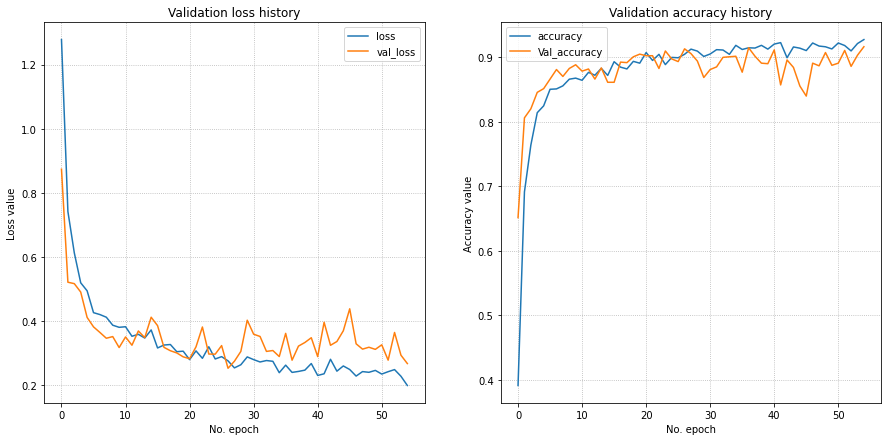

<Figure size 432x288 with 0 Axes>

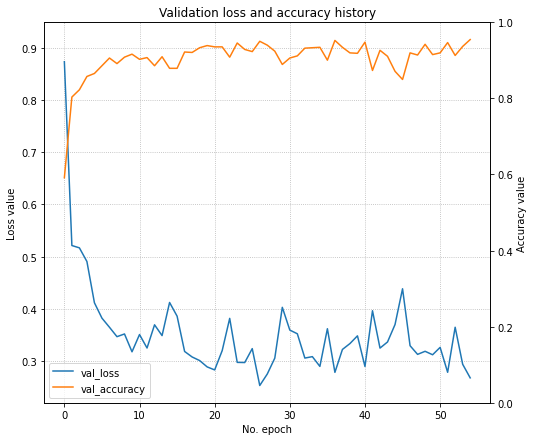

Found 25176 images belonging to 4 classes.
Found 6210 images belonging to 4 classes.
Found 25176 images belonging to 4 classes.
Found 6210 images belonging to 4 classes.
------------------------------------------------------------------------
Entrenamiento para K-fold 3 ...
Epoch 1/55
112/112 [==============================] - 183s 2s/step - loss: 1.4109 - accuracy: 0.3117 - mse: 0.1833 - recall: 0.0499 - precision: 0.5491 - val_loss: 1.0065 - val_accuracy: 0.5576 - val_mse: 0.1415 - val_recall: 0.4161 - val_precision: 0.6438
Epoch 2/55
112/112 [==============================] - 180s 2s/step - loss: 0.9007 - accuracy: 0.6016 - mse: 0.1298 - recall: 0.4665 - precision: 0.6619 - val_loss: 0.5660 - val_accuracy: 0.8010 - val_mse: 0.0760 - val_recall: 0.7377 - val_precision: 0.8462
Epoch 3/55
112/112 [==============================] - 182s 2s/step - loss: 0.6796 - accuracy: 0.7254 - mse: 0.0955 - recall: 0.6610 - precision: 0.7654 - val_loss: 0.4812 - val_accuracy: 0.8446 - val_mse: 0.0632

<Figure size 432x288 with 0 Axes>

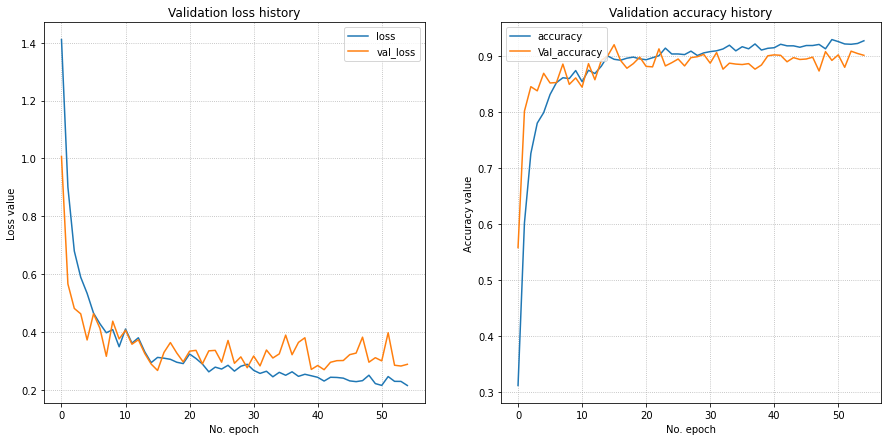

<Figure size 432x288 with 0 Axes>

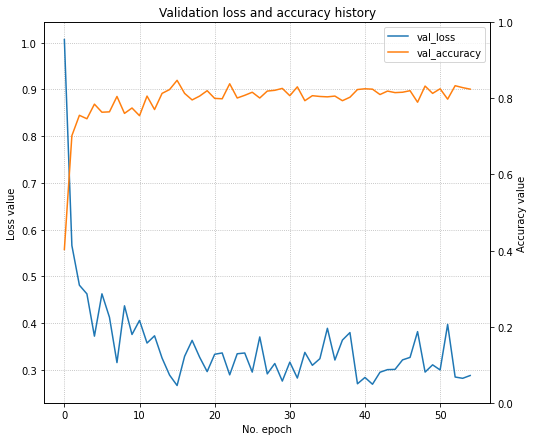

Found 25176 images belonging to 4 classes.
Found 6210 images belonging to 4 classes.
Found 25176 images belonging to 4 classes.
Found 6210 images belonging to 4 classes.
------------------------------------------------------------------------
Entrenamiento para K-fold 4 ...
Epoch 1/55
112/112 [==============================] - 186s 2s/step - loss: 1.2577 - accuracy: 0.4080 - mse: 0.1687 - recall: 0.1907 - precision: 0.6025 - val_loss: 1.0659 - val_accuracy: 0.4762 - val_mse: 0.1532 - val_recall: 0.3380 - val_precision: 0.5408
Epoch 2/55
112/112 [==============================] - 190s 2s/step - loss: 0.7661 - accuracy: 0.6797 - mse: 0.1088 - recall: 0.5932 - precision: 0.7214 - val_loss: 0.5837 - val_accuracy: 0.7566 - val_mse: 0.0829 - val_recall: 0.7146 - val_precision: 0.7843
Epoch 3/55
112/112 [==============================] - 199s 2s/step - loss: 0.6192 - accuracy: 0.7645 - mse: 0.0859 - recall: 0.7151 - precision: 0.7952 - val_loss: 0.4848 - val_accuracy: 0.8339 - val_mse: 0.0659

<Figure size 432x288 with 0 Axes>

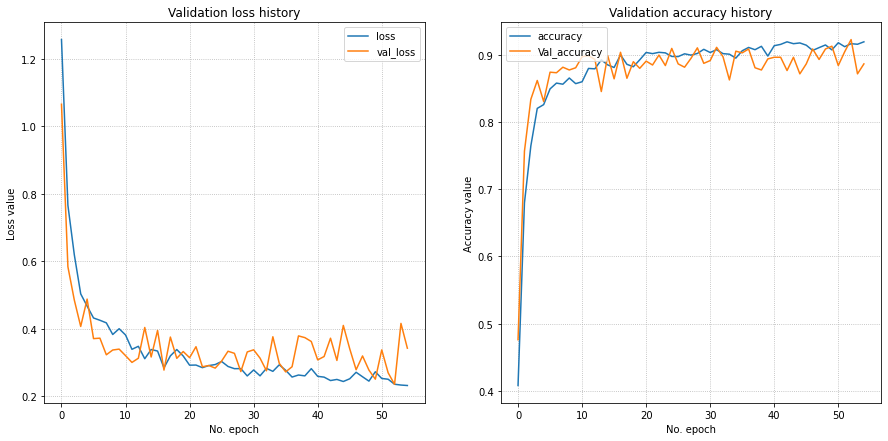

<Figure size 432x288 with 0 Axes>

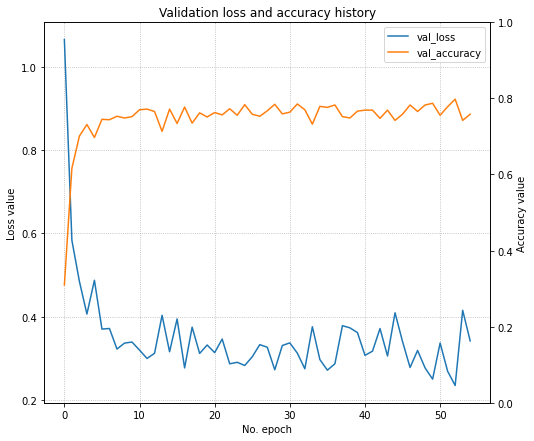

Found 25176 images belonging to 4 classes.
Found 6210 images belonging to 4 classes.
Found 25176 images belonging to 4 classes.
Found 6210 images belonging to 4 classes.
------------------------------------------------------------------------
Entrenamiento para K-fold 5 ...
Epoch 1/55
112/112 [==============================] - 193s 2s/step - loss: 1.2212 - accuracy: 0.4693 - mse: 0.1595 - recall: 0.2503 - precision: 0.6221 - val_loss: 0.7360 - val_accuracy: 0.7031 - val_mse: 0.1037 - val_recall: 0.5946 - val_precision: 0.7635
Epoch 2/55
112/112 [==============================] - 193s 2s/step - loss: 0.8017 - accuracy: 0.6607 - mse: 0.1147 - recall: 0.5647 - precision: 0.7082 - val_loss: 0.6969 - val_accuracy: 0.7179 - val_mse: 0.0983 - val_recall: 0.6538 - val_precision: 0.7593
Epoch 3/55
112/112 [==============================] - 192s 2s/step - loss: 0.6003 - accuracy: 0.7626 - mse: 0.0855 - recall: 0.7201 - precision: 0.7912 - val_loss: 0.4392 - val_accuracy: 0.8438 - val_mse: 0.0583

<Figure size 432x288 with 0 Axes>

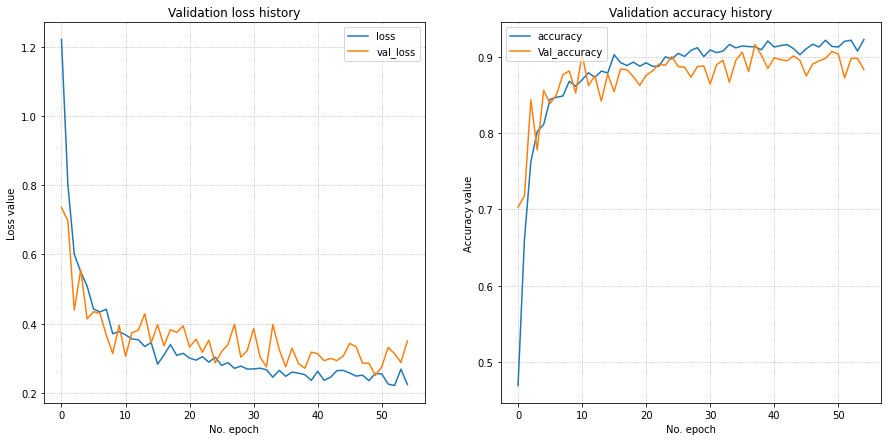

<Figure size 432x288 with 0 Axes>

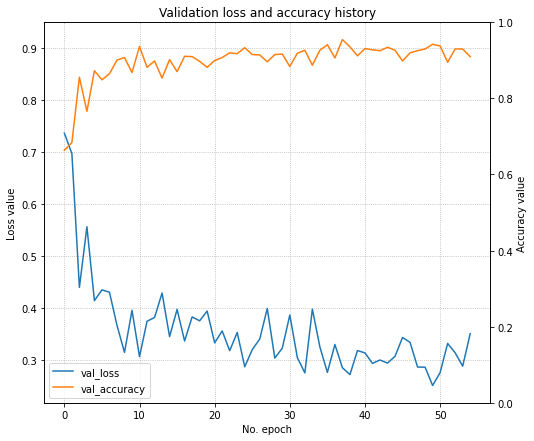

------------------------------------------------------------------------
Score por fold
------------------------------------------------------------------------


IndexError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
# K-fold Cross Validation 
fold_no = 1
ruta=0
for fold_no in range(1,num_folds+1):

  # Generación del modelo
  def modelo():
    vgg=applications.vgg16.VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(496, 496, 3)) # carga el modelo VGG16 en la variable vgg 
    cnn=Sequential()               # crea un modelo vacio del tipo secuencial
    for layer in vgg.layers:       # Transfiere las capas de vgg a cnn
        cnn.add(layer)
    cnn.pop()                      # Elimina la última capa de predicción
    for layer in cnn.layers:       # Recorre y hace que no vuelvan a entrenar 
        layer.trainable=False
    cnn.add(MaxPooling2D(pool_size=tamano_pool))
    cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding ="same", activation='relu'))
    cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding ="same", activation='relu'))
    cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding ="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size=tamano_pool))
    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(clases, activation='softmax')) # agrega capa de 4 neuronas para 4 clases a clasificar
    
    return cnn

  K.clear_session()

  #Preparamos nuestras imagenes de entrenamiento con diferentes transformaciones para generalizar el aprendizaje
  entrenamiento_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
  
  #Preparamos nuestras imagenes de validación
  valid_datagen = ImageDataGenerator(rescale=1. / 255)

  for i in range(1,3):
    #Se leen las imagenes de entrenamiento del directorio
    entrenamiento_generador = entrenamiento_datagen.flow_from_directory(
      rutatrain[ruta],
      target_size=(altura, longitud),
      batch_size=batch_size,
      class_mode='categorical')
    
    #Se leen las imagenes de validación del directorio
    validacion_generador = valid_datagen.flow_from_directory(
      rutaval[ruta],
      target_size=(altura, longitud),
      batch_size=batch_size,
      class_mode='categorical')
    
  #Se generan los pasos de entrenamiento y validación  
  pasos = entrenamiento_generador.n // (entrenamiento_generador.batch_size*7)
  validation_steps = validacion_generador.n // (validacion_generador.batch_size*5)

  #Se compila el modelo
  cnn=modelo()
  #cnn.summary() 
  cnn.compile(optimizer = 'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy','mse',Recall(),Precision()])
 
  
  # Genera impresión de cada iteración de k fold
  print('------------------------------------------------------------------------')
  print(f'Entrenamiento para K-fold {fold_no} ...')

  # Entrenamiento del modelo
  history = cnn.fit(
  entrenamiento_generador,
  steps_per_epoch=pasos,
  epochs=epocas,
  validation_data=validacion_generador,
  validation_steps=validation_steps)

  # Guarda el modelo y pesos entrenados en una carpeta por cada iteración
  target_dir = '/content/Drive/My Drive/IA/Proyectos/modelo/'
  if not os.path.exists(target_dir):
    os.mkdir(target_dir)
  cnn.save('/content/Drive/My Drive/IA/Proyectos/modelo/K'+str(fold_no)+'.h5')
  cnn.save_weights('/content/Drive/My Drive/IA/Proyectos/modelo/Kp'+str(fold_no)+'.h5')


  # Generación de métricas
  scores = cnn.evaluate(validacion_generador, steps=194, verbose=2, callbacks=None)
  print(f'Score para fold {fold_no}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100}%; {cnn.metrics_names[3]} of {scores[3]*100}%; {cnn.metrics_names[4]} of {scores[4]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  se_per_fold.append(scores[3])
  sp_per_fold.append(scores[4])


  # Visualización history o proceso de entrenamiento

  # Plot history: Loss
  plt.figure(figsize=(15,7))
  plt.subplot(121)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Validation loss history')
  plt.ylabel('Loss value')
  plt.xlabel('No. epoch')
  plt.legend(['loss', 'val_loss'], loc='upper right')
  plt.grid(linestyle=':')

  # Plot history: Accuracy
  plt.subplot(122)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Validation accuracy history')
  plt.ylabel('Accuracy value')
  plt.xlabel('No. epoch')
  plt.legend(['accuracy', 'Val_accuracy'], loc='upper left')
  plt.grid(linestyle=':')
  plt.show()
  plt.savefig("/content/Drive/My Drive/IA/Proyectos/modelo/TrainVsVal"+str(fold_no)+".svg", format="svg")
    

  # Plot history: loss vs Accuracy
  plt.figure(figsize=(8, 7))
  plt.plot(history.history['val_loss'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Validation loss and accuracy history')
  plt.xlabel('No. epoch')
  plt.ylabel('Loss value')
  plt.legend(['val_loss', 'val_accuracy'], loc='best')
  plt.grid(linestyle=':')
  plt.twinx()
  plt.ylabel('Accuracy value')
  plt.show()
  plt.savefig("/content/Drive/My Drive/IA/Proyectos/modelo/ValVsVal"+str(fold_no)+".svg", format="svg")


# Incremento de contador de k fold
fold_no = fold_no + 1
ruta = ruta + 1

# Promedio de los score 
print('------------------------------------------------------------------------')
print('Score por fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - Recall: {rc_per_fold[i]}% - Precision: {pc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  
# Tabla de los promedios de métricas de cada iteración de la validación  
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Recall: {np.mean(rc_per_fold)} (+- {np.std(rc_per_fold)})')
print(f'> Precision: {np.mean(pc_per_fold)} (+- {np.std(pc_per_fold)})')
print('------------------------------------------------------------------------')

12. Función de para graficar matriz de confusión

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

13. Cálculo de matriz de confusión para cada modelo de k-fold

Found 6210 images belonging to 4 classes.
******** Confusion Matrix para K-fold 1********
[[1307   70  171    4]
 [   8 1432   22   90]
 [  47   22 1426   57]
 [   1   31   82 1440]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.96      0.84      0.90      1552
         DME       0.92      0.92      0.92      1552
     DRUSSEN       0.84      0.92      0.88      1552
      NORMAL       0.91      0.93      0.92      1554

    accuracy                           0.90      6210
   macro avg       0.91      0.90      0.90      6210
weighted avg       0.91      0.90      0.90      6210



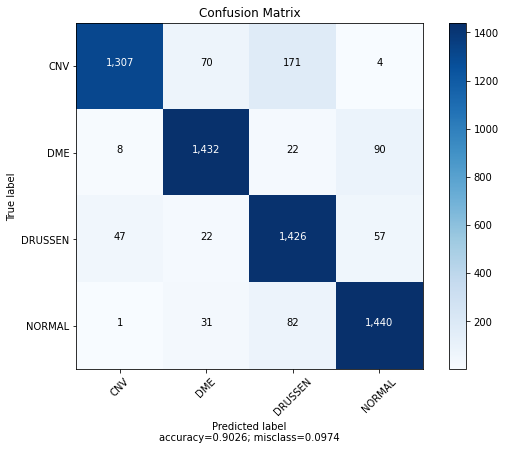

Found 6208 images belonging to 4 classes.
******** Confusion Matrix para K-fold 2********
[[1499   12   41    0]
 [  12 1455   12   73]
 [  51    4 1429   68]
 [   1   27   22 1502]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.96      0.97      0.96      1552
         DME       0.97      0.94      0.95      1552
     DRUSSEN       0.95      0.92      0.94      1552
      NORMAL       0.91      0.97      0.94      1552

    accuracy                           0.95      6208
   macro avg       0.95      0.95      0.95      6208
weighted avg       0.95      0.95      0.95      6208



<Figure size 432x288 with 0 Axes>

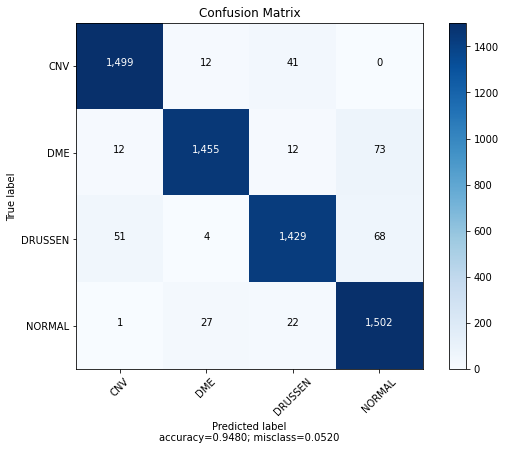

Found 6208 images belonging to 4 classes.
******** Confusion Matrix para K-fold 3********
[[1434   26   92    0]
 [  29 1457   20   46]
 [  41   13 1454   44]
 [   0   45    7 1500]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.95      0.92      0.94      1552
         DME       0.95      0.94      0.94      1552
     DRUSSEN       0.92      0.94      0.93      1552
      NORMAL       0.94      0.97      0.95      1552

    accuracy                           0.94      6208
   macro avg       0.94      0.94      0.94      6208
weighted avg       0.94      0.94      0.94      6208



<Figure size 432x288 with 0 Axes>

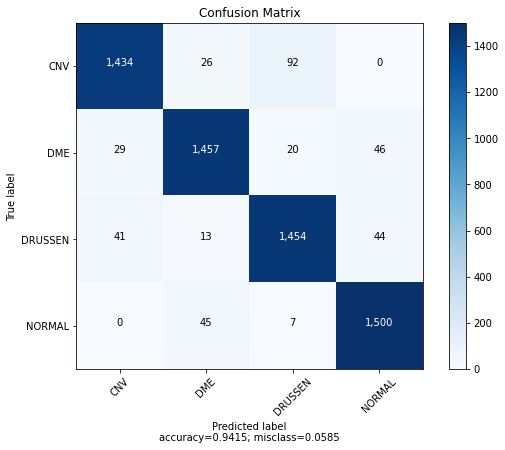

Found 6208 images belonging to 4 classes.
******** Confusion Matrix para K-fold 4********
[[1460   43   45    4]
 [  34 1425    2   91]
 [ 103   16 1337   96]
 [   0   15    3 1534]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.91      0.94      0.93      1552
         DME       0.95      0.92      0.93      1552
     DRUSSEN       0.96      0.86      0.91      1552
      NORMAL       0.89      0.99      0.94      1552

    accuracy                           0.93      6208
   macro avg       0.93      0.93      0.93      6208
weighted avg       0.93      0.93      0.93      6208



<Figure size 432x288 with 0 Axes>

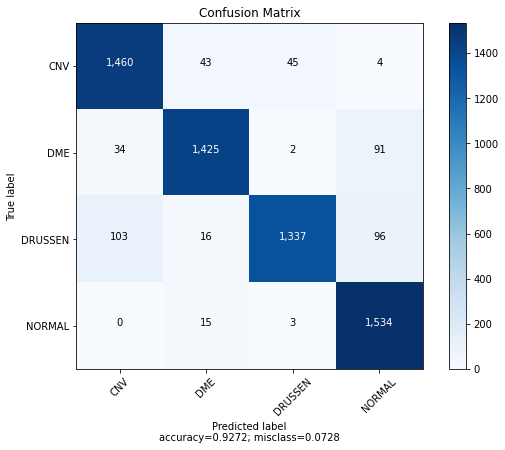

Found 6208 images belonging to 4 classes.
******** Confusion Matrix para K-fold 5********
[[1262   11  276    3]
 [  90 1305   31  126]
 [ 302    3 1206   41]
 [   2   22   22 1506]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.76      0.81      0.79      1552
         DME       0.97      0.84      0.90      1552
     DRUSSEN       0.79      0.78      0.78      1552
      NORMAL       0.90      0.97      0.93      1552

    accuracy                           0.85      6208
   macro avg       0.85      0.85      0.85      6208
weighted avg       0.85      0.85      0.85      6208



<Figure size 432x288 with 0 Axes>

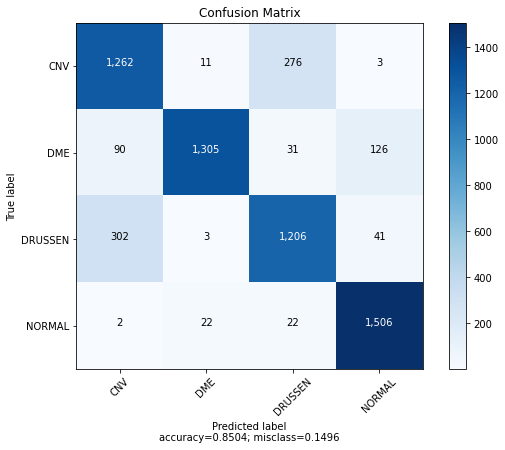

<Figure size 432x288 with 0 Axes>

In [ ]:
fold_no=1
ruta=0
for fold_no in range(1,num_folds+1):
  # Carga modelo
  modelo = '/content/Drive/My Drive/IA/Proyectos/modelo/KV7/K'+str(fold_no)+'.h5'
  pesos_modelo = '/content/Drive/My Drive/IA/Proyectos/modelo/KV7/Kp'+str(fold_no)+'.h5'
  cnn = load_model(modelo)
  cnn.load_weights(pesos_modelo)

  #print(rutaval[ruta])
  #Preparamos nuestras imagenes de validación
  valid_datagen = ImageDataGenerator(rescale=1. / 255)
  #Se leen las imagenes de validación del directorio
  validacion_generador = valid_datagen.flow_from_directory(
  rutaval[ruta],
  target_size=(altura, longitud),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=False)

  #Confution Matrix and Classification Report
  Y_pred = cnn.predict(validacion_generador)
  y_pred = np.argmax(Y_pred, axis=1)
 
  print('******** Confusion Matrix para K-fold '+str(fold_no)+ '********')
  cm=confusion_matrix(validacion_generador.classes, y_pred)
  print(cm)
  print('Classification Report')
  target_names = ['CNV', 'DME', 'DRUSSEN', 'NORMAL']
  print(classification_report(validacion_generador.classes, y_pred, target_names=target_names))

  plot_confusion_matrix(cm,
  normalize    = False,
  target_names = ['CNV', 'DME', 'DRUSSEN', 'NORMAL'],
  title        = "Confusion Matrix")
  plt.savefig('/content/Drive/My Drive/IA/Proyectos/modelo/KV7/cm'+str(fold_no)+'.svg')
  ruta = ruta + 1
fold_no = fold_no + 1

14. Cargue del modelo para predicción (prueba)

In [ ]:
# Carga modelo
modelo = '/content/Drive/My Drive/IA/Proyectos/modelo/KV7/K2.h5'
pesos_modelo = '/content/Drive/My Drive/IA/Proyectos/modelo/KV7/Kp2.h5'
cnn = load_model(modelo)
cnn.load_weights(pesos_modelo)
#cnn.summary()

15. Ruta de imagenes de test

In [ ]:
data_test = '/content/Drive/My Drive/IA/Proyectos/test/'

16. Preparación de imágenes de test

In [ ]:
#Preparamos nuestras imagenes de test
test_datagen = ImageDataGenerator(rescale=1. / 255)
#Se leen las imagenes de test del directorio
test_generador = test_datagen.flow_from_directory(
  data_test,
  target_size=(altura, longitud),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=False)

Found 3448 images belonging to 4 classes.


17. Cálculo de la predicción con conjunto test

In [ ]:
#predicción conjunto test
t_pred = cnn.predict(test_generador)
t_pred = np.argmax(t_pred, axis=1)

18. Matriz de confusión y reporte de métricas

In [ ]:
print('Confusion Matrix')
cm=confusion_matrix(test_generador.classes, t_pred)
print(cm)
print('Classification Report')
target_names = ['CNV', 'DME', 'DRUSSEN', 'NORMAL']
print(classification_report(test_generador.classes, t_pred, target_names=target_names))

Confusion Matrix
[[807   9  43   3]
 [  1 800   4  57]
 [ 23   1 809  29]
 [  0   3  26 833]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.97      0.94      0.95       862
         DME       0.98      0.93      0.96       862
     DRUSSEN       0.92      0.94      0.93       862
      NORMAL       0.90      0.97      0.93       862

    accuracy                           0.94      3448
   macro avg       0.94      0.94      0.94      3448
weighted avg       0.94      0.94      0.94      3448



19. Gráfica de la matriz de confusión

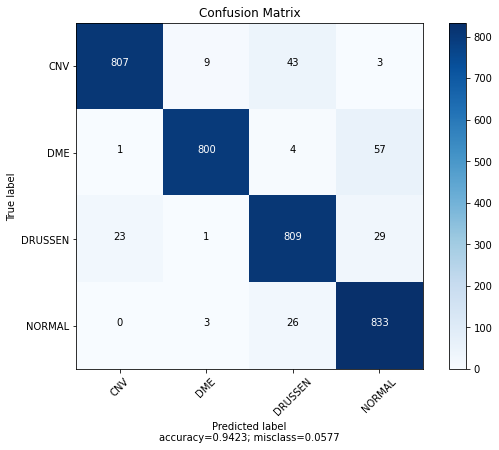

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_confusion_matrix(cm,
normalize    = False,
target_names = ['CNV', 'DME', 'DRUSSEN', 'NORMAL'],
title        = "Confusion Matrix")
plt.savefig('/content/Drive/My Drive/IA/Proyectos/modelo/cmtest.svg')